## Goodreads Book Recommender

#### Introduction

This notebook generates book recommendations using two methods: collabortive filtering based on reader similarity and collaborative filtering based on predicted book ratings. The former uses KNN while the latter uses two forms of matrix factorization - first by singular value decomposition (SVD) and next by gradient descent using alternating least squares (ALS). 

Book and user ratings data come from the [Goodreads Book Graph Datasets](https://github.com/MengtingWan/goodreads]) produced by Mengting Wan, Rishabh Misra, Ndapa Nakashole, and Julian McAuley at UCSD. It has been imported, cleaned, and preprocessed in [00_prep_goodreads_data.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/00_prep_goodreads_data.ipynb). Genres, which are important for filtering recommendations but missing from the UCSD dataset, are inferred by topic modeling via latent dirichlet allocation (LDA) on book descriptions in [01_infer_genres.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/01_infer_genres.ipynb).

The target reader, for whom recommendations are being made in this notebook, is myself. To substitute your own Goodreads data and get personalized recommendations, go to the [Import/Export page](https://www.goodreads.com/review/import) on your Goodreads profile, download your books, and save as ```./data/goodreads_library_export.csv``` 

#### Contents

[Part 0: Preprocessing](#part-0-preprocessing)
- [0.1 - Load and Prepare Data](#01---load-and-prepare-data)
- [0.1 - Write Functions to Process Recommendations](#02---write-functions-to-process-recommendations)

[Part 1: Collaborative Filtering Based on Reader Similarity with KNN](#part-1---collaborative-filtering-based-on-reader-similarity-with-knn)
- [1.1 - Find Similar Readers](#11---find-similar-readers)
- [1.2 - Generate Recommendations](#12---generate-recommendations)


[Part 2: Collaborative Filtering Based on Predicted Ratings with Matrix Factorization](#part-2---collaborative-filtering-based-on-predicted-ratings-with-matrix-factorization)
- [2.1 - Factorize User-Rating Matrix with SVD](#21---factorize-user-rating-matrix-with-svd)
- [2.2 - Generate Recommendations by Predicting Ratings](#22---generate-recommendations-by-predicting-ratings)
- [2.3 - Matrix Factorization with Gradient Descent](#23-matrix-factorization-with-gradient-descent)

## Part 0: Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from IPython.display import display
from scipy.sparse.linalg import svds

In [2]:
# Set global variable of "sparse" or "dense"
# "sparse" will have user-item matrix with all books, "dense" only those in df_books
SPARSITY = "dense" 

# Choose K for small med and large neighborhoods
SM, MD, LG = 200, 750, 2000

### 0.1 - Load and Prepare Data

In [3]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres, how="left", on="book_id")

# Filter out kids books
df_books = df_books[df_books.loc[:,"children":"comic"].sum(axis=1) < 2]

In [4]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [5]:
# Create df_reviews that is less sparse than original
if SPARSITY == "dense":
    in_df_books = book_index["book_id"].isin(df_books["book_id"])
    book_index = book_index[in_df_books].reset_index().drop("index", axis=1)
    df_reviews = df_reviews[:, in_df_books]
print(f"User-Item Matrix: {df_reviews.shape[0]:,} readers by {df_reviews.shape[1]:,} books")    

User-Item Matrix: 245,119 readers by 315,354 books


In [7]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating", "Title"]]\
    .rename(columns={"Book Id":"book_id", "My Rating":"rating", "Title":"title"}).query("rating > 0")
print(f"Target reader ratings: {my_books.shape[0]}")

# First match on book_id
my_books_1 = pd.merge(
                my_books, df_books[["book_id", "title"]], 
                how="inner", on="book_id", suffixes=["_mb","_dfb"]
            ).rename(columns={"title_dfb":"title"}).drop("title_mb", axis=1)
print(f"Matching on book_id: {my_books_1.shape[0]}")

# Next match on title
my_books_2 = pd.merge(
    my_books[~my_books["book_id"].isin(my_books_1["book_id"])], # not matched on id
    df_books[["book_id", "title", "ratings_count", "avg_rating"]], 
    how="inner", on="title", suffixes=["_mb","_dfb"]
    ).sort_values(["title", "ratings_count"], ascending=False)\
     .drop_duplicates(subset=["title"])\
     .rename(columns={"book_id_dfb":"book_id"})
print(f"Matching on title: {my_books_2[~my_books_2['book_id'].isin(my_books_1['book_id'])].shape[0]}")

# Concat matching on book_id and matching on title
my_books_3 = pd.concat([my_books_1, my_books_2[["book_id", "rating", "title"]]])\
               .drop_duplicates(subset="title")
print(f"Total matches: {my_books_3.shape[0]}, {(my_books_3.shape[0] / my_books.shape[0]):.2%} of total")

# Reshape to sparse matrix dimensions
my_books_4 = pd.merge(book_index, my_books_3, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books_4["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])
df_reviews = sparse.csr_matrix(df_reviews)

# Normalize reviews within readers for KNN
norm = Normalizer()
df_reviews_norm = norm.fit_transform(df_reviews) 

Target reader ratings: 168
Matching on book_id: 80


Matching on title: 20
Total matches: 100, 59.52% of total


In [8]:
# Set target reader to make recommendations for
target = df_reviews.shape[0] - 1

#### 0.2 - Write Functions to Process Recommendations

In [9]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(
            columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i])
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(
                                columns={0:"uid",1:"book_index",2:"user_rating"}
                            )

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(
                                ind_books.reset_index(), neighbor_user_ratings, 
                                how="inner", left_on="index", right_on="book_index"
                            )
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#(?:[2-9]|[1-9]\d+)"
    regex2 = r"Vol. (?:[0-9]|[1-9]\d+)"
    regex3 = r"Volume (?:[0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex3)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame(
                            [target_user_books, target_user_book_rat]).T.rename(
                                columns={0:"book_index",1:"user_rating"}
                        )
    target_user_ratings = pd.merge(
                            ind_books.reset_index(), target_user_ratings,
                            how="inner", left_on="index", right_on="book_index"
                        )
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings, dists

In [10]:
# Function to show top recs for each genre
def show_top_recs_by_genre(
        target, others, preds=None, how=["KNN", "MF"], whose_genres=["target", "neighbors"], 
        n_genres=5, min_score=3.9, min_ratings=400, n_recs=15, write_to_excel=False):

    if whose_genres == "target":
        genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    else:
        genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))    
    
    genres = []
    results = []
    # Loop through genres in descending relevance order and print top recs
    for genre in genre_ranking.index[0:n_genres]:        
        
        g = float(genre[6:])
        if how == "KNN":
            highest_rated_recs_genre = others.query("main_genre == @g")\
                .groupby(["title", "avg_rating", "ratings_count", "year", "url"])["book_id"]\
                .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)
        
        elif how == "MF":
            highest_rated_recs_genre = preds.query("main_genre == @g")\
            .sort_values(by="predicted_rating", ascending=False)                

        highest_rated_recs_genre = highest_rated_recs_genre.query(
                                        "ratings_count > @min_ratings & avg_rating > @min_score"
                                    )

        # Print genre name and descriptor
        for nt in genre_descriptors.itertuples():
            genre_rep = genre.replace("_"," ")
            if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
                gs = (nt.genre_string)
        
        genres.append(gs)
        results.append(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(50))

        print(gs)
        display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(n_recs))
        print("_____\n")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        writer.close

In [11]:
# Functions to show top rated and most popular among similar readers
def neighbors_most_popular(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):
    
    popular_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
        .nlargest(n, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

    popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / 
                                                    others["uid"].nunique()).map('{:.1%}'.format)
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
                
        writer.close

    return popular_recs[["title","avg_rating","ratings_count","year","percent_similar_users_read","url"]]


def neighbors_top_rated(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):

    highest_rated_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .nlargest(n, "avg_rating").drop(columns="book_id")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
                
        writer.close

    return highest_rated_recs

In [12]:
# Function to plot neighbors' and target's top genres
def plot_top_genres(others, target):

    # Get genre rankings for target and neighbors
    target_genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"target"})
    target_genre_ranking = target_genre_ranking.div(target_genre_ranking.sum(axis=0), axis=1)

    neighbor_genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"neighbor"})
    neighbor_genre_ranking = neighbor_genre_ranking.div(neighbor_genre_ranking.sum(axis=0), axis=1)

    genre_rankings = pd.merge(
            target_genre_ranking, neighbor_genre_ranking, left_index=True, right_index=True
            ).reset_index()

    # Plot target genre pref
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='target',
        s=150,
        edgecolors='black',
        linewidths = 0.75,
        label='Target Reader',
        zorder=2,
        )

    # Plot neighbors genre pref
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='neighbor',
        label='Similar Readers',
        s=150,
        zorder=3
        )

    # Iterate through each genre and plot line connecting 2 points
    for ind in list(genre_rankings['index']):
    
        # Plot line connecting points
        plt.plot([genre_rankings[genre_rankings['index']==ind]['target'],
                    genre_rankings[genre_rankings['index']==ind]['neighbor']],
                    [ind, ind],
                    color='#565A5C',
                    alpha=0.9,                    
                    linestyle=(0, (1,1)),
                    linewidth=2.5,
                    zorder=1
                    )

    # Set chart details
    plt.legend(bbox_to_anchor=(1,1), loc="upper left", borderpad=1)
    ax.yaxis.grid(True, alpha=0.4) # Create y gridlines
    ax.xaxis.grid(True, alpha=0.4) # Create x gridlines
    plt.xlabel("Genre preference")
    plt.ylabel(None)
    plt.title('Top Genres for Target Reader and Similar Readers', fontsize=14)
    plt.show()

## Part 1 - Collaborative Filtering Based on Reader Similarity with KNN

In this section, we use K-Nearest Neighbors (KNN) to find the readers most similar to our target reader. Each reader's ratings on all books in the dataset are encoded as vectors where unread books are given a value of 0. We use cosine similarity to find the users whose ratings are most similar to the target and then filter among their books to find the most popular and highest rated.

### 1.1 - Find Similar Readers

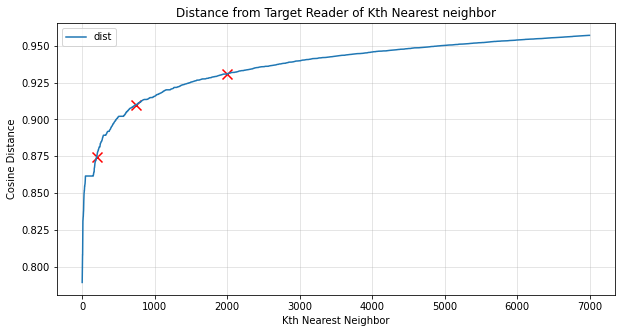

In [13]:
# Take a very large neighborhood to see how reader similarity decreases with K
n, t, dists = find_neighbors(10000, target, df_reviews_norm, book_index, df_books)

# Plot distance by kth closest neighbor
fig, ax = plt.subplots(figsize=(10,5))
pd.DataFrame(dists.T).rename(columns={0:"dist"})[1:7000].plot(ax=ax)
plt.title("Distance from Target Reader of Kth Nearest neighbor")
plt.xlabel("Kth Nearest Neighbor")
plt.ylabel("Cosine Distance")
ax.yaxis.grid(True, alpha=0.4) # Create y gridlines
ax.xaxis.grid(True, alpha=0.4) # Create x gridlines
plt.scatter(SM, dists[0,SM], color="red", marker="x", s=100)
plt.scatter(MD, dists[0,MD], color="red", marker="x", s=100)
plt.scatter(LG, dists[0,LG], color="red", marker="x", s=100)
plt.show()

In [14]:
# Perform KNN on user rating matrix
sm_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                        SM, target, df_reviews, book_index, df_books)

# Find med number of similar users than before to get broader pool of potentially relevant books
med_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                    MD, target, df_reviews, book_index, df_books)

# Find larger number of similar users 
lg_neighborhoodhood_ratings, target_user_ratings, d = find_neighbors(
                                                        LG, target, df_reviews, book_index, df_books)

print(f"Small neighborhood contains {sm_neighborhood_ratings['book_index'].nunique():,} books")
print(f"Medium neighborhood contains {med_neighborhood_ratings['book_index'].nunique():,} books")
print(f"Large neighborhood contains {lg_neighborhoodhood_ratings['book_index'].nunique():,} books")

Small neighborhood contains 775 books
Medium neighborhood contains 4,161 books
Large neighborhood contains 11,542 books


<a id='Part1.2'></a>
### 1.2 - Generate Recommendations

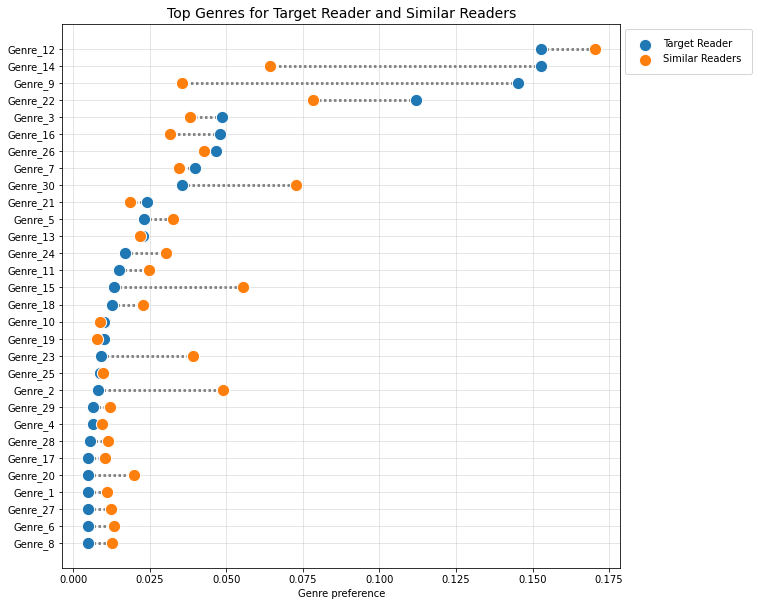

In [15]:
# Show top genres
plot_top_genres(sm_neighborhood_ratings, target_user_ratings)

In [16]:
# View most popular books among neighbors
neighbors_most_popular(sm_neighborhood_ratings, 15, min_ratings=400, write_to_excel=False)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
410,The Martian,4.39,435440.0,2014.0,11.8%,https://www.goodreads.com/book/show/18007564-t...
263,Ready Player One,4.31,376328.0,2011.0,8.2%,https://www.goodreads.com/book/show/9969571-re...
236,"Old Man's War (Old Man's War, #1)",4.23,100702.0,2007.0,7.1%,https://www.goodreads.com/book/show/51964.Old_...
287,Seveneves,3.98,47286.0,2015.0,7.1%,https://www.goodreads.com/book/show/22816087-s...
478,"The Way of Kings (The Stormlight Archive, #1)",4.64,151473.0,2010.0,5.9%,https://www.goodreads.com/book/show/7235533-th...
417,The Name of the Wind (The Kingkiller Chronicle...,4.55,416634.0,2007.0,5.9%,https://www.goodreads.com/book/show/186074.The...
370,"The Final Empire (Mistborn, #1)",4.43,216149.0,2006.0,5.9%,https://www.goodreads.com/book/show/68428.The_...
397,"The Hunger Games (The Hunger Games, #1)",4.34,4899965.0,2008.0,5.9%,https://www.goodreads.com/book/show/2767052-th...
198,"Leviathan Wakes (The Expanse, #1)",4.20,72492.0,2011.0,5.9%,https://www.goodreads.com/book/show/8855321-le...
95,Dark Matter,4.10,75794.0,2016.0,5.9%,https://www.goodreads.com/book/show/27833670-d...


In [17]:
# View highest rated books among similar readers
neighbors_top_rated(sm_neighborhood_ratings, 15, min_ratings=400, write_to_excel=False)

,title,avg_rating,ratings_count,year,url
478,"The Way of Kings (The Stormlight Archive, #1)",4.64,151473.0,2010.0,https://www.goodreads.com/book/show/7235533-th...
390,The Hate U Give,4.60,49663.0,2017.0,https://www.goodreads.com/book/show/32075671-t...
417,The Name of the Wind (The Kingkiller Chronicle...,4.55,416634.0,2007.0,https://www.goodreads.com/book/show/186074.The...
38,Arcanum Unbounded: The Cosmere Collection,4.54,6493.0,2016.0,https://www.goodreads.com/book/show/28595941-a...
295,"Six of Crows (Six of Crows, #1)",4.46,102183.0,2015.0,https://www.goodreads.com/book/show/23437156-s...
133,Ficciones,4.46,29502.0,1944.0,https://www.goodreads.com/book/show/426504.Fic...
370,"The Final Empire (Mistborn, #1)",4.43,216149.0,2006.0,https://www.goodreads.com/book/show/68428.The_...
475,"The Walking Dead, Compendium 1",4.43,58434.0,2009.0,https://www.goodreads.com/book/show/6465707-th...
13,A Night Without Stars,4.41,1758.0,2016.0,https://www.goodreads.com/book/show/28530221-a...
50,Behave: The Biology of Humans at Our Best and ...,4.40,830.0,2017.0,https://www.goodreads.com/book/show/31170723-b...


In [18]:
# View highest rated books by each of the top genres
show_top_recs_by_genre(
    target=target_user_ratings, 
    others=sm_neighborhood_ratings, 
    how="KNN", 
    whose_genres="target", 
    n_genres=5, 
    min_score=3.9, 
    min_ratings=400, 
    n_recs=15,
    write_to_excel=False
)

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,ratings_count,url
106,"The Walking Dead, Compendium 1",4.43,58434.0,https://www.goodreads.com/book/show/6465707-th...
2,A Night Without Stars,4.41,1758.0,https://www.goodreads.com/book/show/28530221-a...
93,The Martian,4.39,435440.0,https://www.goodreads.com/book/show/18007564-t...
105,The Ultimate Hitchhiker's Guide to the Galaxy,4.38,225626.0,https://www.goodreads.com/book/show/13.The_Ult...
104,The Stand,4.34,449730.0,https://www.goodreads.com/book/show/149267.The...
46,"Illuminae (The Illuminae Files, #1)",4.31,48266.0,https://www.goodreads.com/book/show/23395680-i...
111,"We Are Legion (We Are Bob) (Bobiverse, #1)",4.30,17174.0,https://www.goodreads.com/book/show/32109569-w...
49,Judas Unchained,4.30,21306.0,https://www.goodreads.com/book/show/45244.Juda...
22,Children of Time,4.29,6302.0,https://www.goodreads.com/book/show/25499718-c...
62,Pandora's Star,4.24,28964.0,https://www.goodreads.com/book/show/45252.Pand...


_____

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,ratings_count,url
28,On Tyranny: Twenty Lessons from the Twentieth ...,4.29,9145.0,https://www.goodreads.com/book/show/33917107-o...
29,Our Revolution: A Future to Believe In,4.29,2430.0,https://www.goodreads.com/book/show/31741420-o...
36,The Big Short: Inside the Doomsday Machine,4.26,37174.0,https://www.goodreads.com/book/show/6463967-th...
8,Buffett: The Making of an American Capitalist,4.24,6881.0,https://www.goodreads.com/book/show/1155.Buffett
16,"Elon Musk: Tesla, SpaceX, and the Quest for a ...",4.24,11750.0,https://www.goodreads.com/book/show/22535480-e...
4,"American Tabloid (Underworld USA, #1)",4.21,10342.0,https://www.goodreads.com/book/show/36064.Amer...
50,"Titan: The Life of John D. Rockefeller, Sr.",4.19,8970.0,https://www.goodreads.com/book/show/16121.Titan
7,"Blood Meridian, or the Evening Redness in the ...",4.18,72755.0,https://www.goodreads.com/book/show/394535.Blo...
45,The Sleepwalkers: How Europe Went to War in 1914,4.18,3830.0,https://www.goodreads.com/book/show/18669169-t...
15,Daemon (Daemon #1),4.17,9355.0,https://www.goodreads.com/book/show/6665847-da...


_____

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,ratings_count,url
8,India After Gandhi: The History of the World's...,4.35,9652.0,https://www.goodreads.com/book/show/356824.Ind...
1,A Thousand Splendid Suns,4.34,835172.0,https://www.goodreads.com/book/show/128029.A_T...
16,The Emperor of All Maladies: A Biography of Ca...,4.29,49534.0,https://www.goodreads.com/book/show/7170627-th...
4,City of Thieves,4.28,69955.0,https://www.goodreads.com/book/show/1971304.Ci...
6,Half of a Yellow Sun,4.28,48752.0,https://www.goodreads.com/book/show/18749.Half...
25,To Kill a Mockingbird,4.26,3255518.0,https://www.goodreads.com/book/show/2657.To_Ki...
27,V for Vendetta,4.25,212464.0,https://www.goodreads.com/book/show/5805.V_for...
3,Bury My Heart at Wounded Knee: An Indian Histo...,4.21,41180.0,https://www.goodreads.com/book/show/76401.Bury...
9,Kindred,4.19,45708.0,https://www.goodreads.com/book/show/60931.Kindred
12,Sophie's Choice,4.18,67718.0,https://www.goodreads.com/book/show/228560.Sop...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,ratings_count,url
5,Behave: The Biology of Humans at Our Best and ...,4.40,830.0,https://www.goodreads.com/book/show/31170723-b...
64,Watchmen,4.35,406669.0,https://www.goodreads.com/book/show/472331.Wat...
19,Letters to a Young Poet,4.34,25895.0,https://www.goodreads.com/book/show/46199.Lett...
52,The Master and Margarita,4.32,136321.0,https://www.goodreads.com/book/show/117833.The...
29,Stories of Your Life and Others,4.27,17769.0,https://www.goodreads.com/book/show/223380.Sto...
22,Pride and Prejudice,4.25,2078406.0,https://www.goodreads.com/book/show/1885.Pride...
46,The Hero With a Thousand Faces,4.24,18378.0,https://www.goodreads.com/book/show/588138.The...
37,The Complete Cosmicomics,4.22,776.0,https://www.goodreads.com/book/show/6018080-th...
35,The Best Short Stories,4.21,1276.0,https://www.goodreads.com/book/show/70239.The_...
20,Meditations,4.20,45727.0,https://www.goodreads.com/book/show/30659.Medi...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,ratings_count,url
14,Man's Search for Meaning,4.33,179906.0,https://www.goodreads.com/book/show/4069.Man_s...
8,Falling Upward: A Spirituality for the Two Hal...,4.24,4884.0,https://www.goodreads.com/book/show/9963483-fa...
3,Becoming Wise: An Inquiry into the Mystery and...,4.22,1683.0,https://www.goodreads.com/book/show/25894085-b...
6,"Desiring the Kingdom: Worship, Worldview, and ...",4.22,1659.0,https://www.goodreads.com/book/show/5944774-de...
13,Love Is a Dog from Hell,4.16,19804.0,https://www.goodreads.com/book/show/23534.Love...
17,Reminiscences of a Stock Operator,4.16,7916.0,https://www.goodreads.com/book/show/100779.Rem...
25,The Obstacle Is the Way: The Timeless Art of T...,4.11,13544.0,https://www.goodreads.com/book/show/18668059-t...
26,The Power of Now: A Guide to Spiritual Enlight...,4.11,109355.0,https://www.goodreads.com/book/show/6708.The_P...
7,Einstein: His Life and Universe,4.08,73712.0,https://www.goodreads.com/book/show/10884.Eins...
10,How Will You Measure Your Life?,4.06,11938.0,https://www.goodreads.com/book/show/13425570-h...


_____



## Part 2 - Collaborative Filtering Based on Predicted Ratings with Matrix Factorization

In sections [2.1](#21---factorize-user-rating-matrix-with-svd) and [2.2](#22---generate-recommendations-by-predicting-ratings) we use singular value decomposition (SVD) to factorize the user-rating matrix generated from the 1500 most similar readers to the target reader, as determined by KNN. SVD decomposes our $m * n$ user-rating matrix $R$ into 3 smaller matrices: $$R = U \Sigma \mathbf{V}^\top$$ where $U$, the left singular vectors, represents an $m * k$ embedding space of user features and $\mathbf{V}^\top$, the right singular vectors, represents a $k * n$ embedding of book features. Estimated ratings come from multiplying the decomposed matrices together to approximate $R$. 

The advantage of SVD is its simplicity and computational efficiency. The disadvantage is that it requires unseen ratings to be encoded as 0 and therefore all predicted ratings on unread books are near zero rather than more realistic values. 

-----

In section [2.3](#23-matrix-factorization-with-gradient-descent) we use gradient descent to train user and book embedding matrices $P$ and $Q$. We minimize the loss function: $$L = (r_{ij} - \sum_{k=1}^{K} p_{ik}q_{kj})^2 + \frac{\beta}{2}\sum_{k=1}^{K}(||P||^2 + ||Q||^2)$$ for all $r_{ij} > 0$ using alternating least squares. After training, we reconstruct $R$ matrix by multiplyting $P * Q$. See [here](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/) for a helpful description of th math.

The advantage of gradient descent is that we can train the model on nonzero ratings (i.e. only for books users have actually rated) and apply it to unread books, which yields realistic rating predictions. The downside is that it is computationally very expensive. Larger user-raing $R$ matrices have exponentially more values than smaller ones, so there is a limit to how many nearest neighbors we can use to generate the full set of book ratings to consider. 

#### 2.1 - Factorize User-Rating Matrix with SVD

In [19]:
# Choose neighborhood size for SVD
svd_neighborhood_ratings = lg_neighborhoodhood_ratings

In [20]:
# Get unique users and books to slice df_reviews
svd_neighbor_index = svd_neighborhood_ratings["uid"].unique()
svd_neighbor_index = np.append(svd_neighbor_index, target)
svd_neighbor_book_index = svd_neighborhood_ratings["book_index"].unique()
svd_neighbor_book_index = np.append(svd_neighbor_book_index, target_user_ratings["book_index"].unique())

print(f"Neighborhood contains {svd_neighbor_book_index.shape[0]:,} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, svd_neighbor_book_index]
R = R[svd_neighbor_index, :]

Neighborhood contains 11,642 books


In [21]:
# Decompose user ratings matrix R with SVD
U, sigma, Vt = svds(R, k=50)
sigma = np.diag(sigma)

# Convert to sparse matrix
U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

#### 2.2 - Generate Recommendations by Predicting Ratings

In [22]:
# Get predictions
all_user_predicted_ratings = U.dot(sigma) @ Vt
df_preds = pd.DataFrame(
                all_user_predicted_ratings.toarray(), columns=svd_neighbor_book_index, index=svd_neighbor_index
                ).reset_index()

In [23]:
# Get top recs from predictions
def get_recs(preds, target_reader, book_ind, books, write_to_excel=False):
    
    target_pred_books = preds[preds["index"] == target_reader].columns[1:]
    target_pred_ratings = preds[preds["index"] == target_reader].values[0][1:]

    # Put into df with relevant info from df_books
    top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                    .sort_values(by="predicted_rating", ascending=False)\
                    .merge(book_ind.reset_index(), left_on="book_index", right_on="index")\
                    .merge(
                        books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]],
                        on="book_id"
                    )\
                    .drop(columns=["index", "book_id"])

    # Filter out already read books
    top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
    top_preds.drop(["book_index"], axis=1, inplace=True)

    if write_to_excel == True:
        # Write to excel
        path = wd + "/data/book_recs.xlsx"
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        writer.close

    return top_preds

In [24]:
# View books with highest target user predicted score
top_preds = get_recs(df_preds, target, book_index, df_books, write_to_excel=False)
top_preds[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 4.15 & ratings_count > 750").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
37,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20,1.297787,940154.0,1995.0,https://www.goodreads.com/book/show/11.The_Hit...
40,"I, Robot (Robot #0.1)",4.17,1.220383,201196.0,2004.0,https://www.goodreads.com/book/show/41804.I_Robot
55,Ready Player One,4.31,0.879022,376328.0,2011.0,https://www.goodreads.com/book/show/9969571-re...
62,The Last Lecture,4.25,0.853402,245804.0,2008.0,https://www.goodreads.com/book/show/2318271.Th...
65,The Kite Runner,4.26,0.840100,1848782.0,2004.0,https://www.goodreads.com/book/show/77203.The_...
69,"Lamb: The Gospel According to Biff, Christ's C...",4.26,0.812360,120154.0,2004.0,https://www.goodreads.com/book/show/28881.Lamb
70,The Amazing Adventures of Kavalier & Clay,4.17,0.808445,149976.0,2000.0,https://www.goodreads.com/book/show/3985.The_A...
76,The Brothers Karamazov,4.31,0.779302,158410.0,2002.0,https://www.goodreads.com/book/show/4934.The_B...
77,"The Long Way to a Small, Angry Planet (Wayfare...",4.18,0.775204,15139.0,2014.0,https://www.goodreads.com/book/show/22733729-t...
81,Man's Search for Meaning,4.33,0.736746,179906.0,2006.0,https://www.goodreads.com/book/show/4069.Man_s...


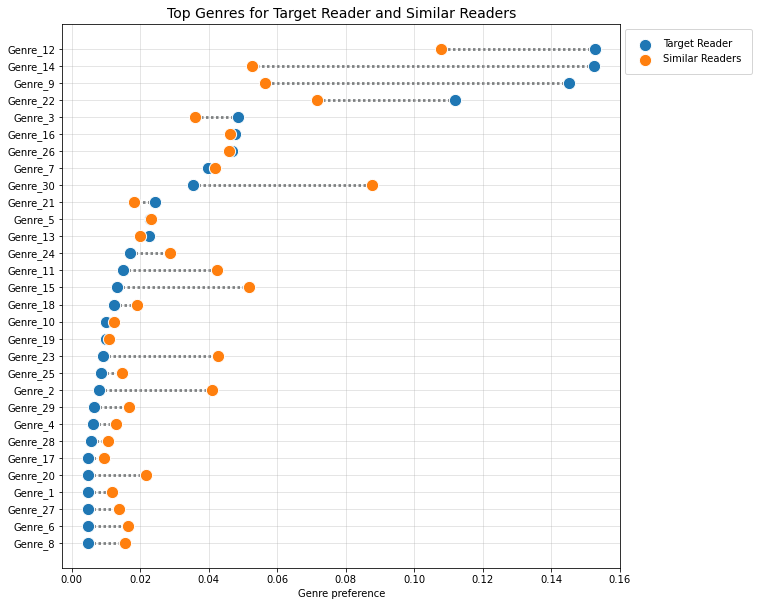

In [25]:
# Show top genres
plot_top_genres(svd_neighborhood_ratings, target_user_ratings)

In [26]:
# View most popular books among neighbors
popular_recs = neighbors_most_popular(svd_neighborhood_ratings, 50, min_ratings=400, write_to_excel=False)
popular_recs.head(15)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
4673,The Martian,4.39,435440.0,2014.0,8.4%,https://www.goodreads.com/book/show/18007564-t...
3074,Ready Player One,4.31,376328.0,2011.0,8.2%,https://www.goodreads.com/book/show/9969571-re...
4751,The Name of the Wind (The Kingkiller Chronicle...,4.55,416634.0,2007.0,5.7%,https://www.goodreads.com/book/show/186074.The...
4449,"The Hunger Games (The Hunger Games, #1)",4.34,4899965.0,2008.0,5.0%,https://www.goodreads.com/book/show/2767052-th...
402,Animal Farm,3.88,1928931.0,2003.0,4.7%,https://www.goodreads.com/book/show/7613.Anima...
4308,The Girl on the Train,3.88,1076144.0,2015.0,4.7%,https://www.goodreads.com/book/show/22557272-t...
4208,The Fault in Our Stars,4.26,2429317.0,2012.0,4.2%,https://www.goodreads.com/book/show/11870085-t...
2283,"Leviathan Wakes (The Expanse, #1)",4.20,72492.0,2011.0,3.7%,https://www.goodreads.com/book/show/8855321-le...
378,"Ancillary Justice (Imperial Radch, #1)",3.97,40736.0,2013.0,3.3%,https://www.goodreads.com/book/show/17333324-a...
2770,"Old Man's War (Old Man's War, #1)",4.23,100702.0,2007.0,3.2%,https://www.goodreads.com/book/show/51964.Old_...


In [27]:
# Highest rated books among similar readers
top_rated = neighbors_top_rated(svd_neighborhood_ratings, min_ratings=400, write_to_excel=False)
top_rated.head(15)

,title,avg_rating,ratings_count,year,url
2897,Patrick O'Brian's Aubrey/Maturin Series,4.83,420.0,2010.0,https://www.goodreads.com/book/show/8432716-pa...
5380,"The Way of Kings, Part 2 (The Stormlight Archi...",4.78,7803.0,2011.0,https://www.goodreads.com/book/show/11221285-t...
1246,ESV Study Bible,4.76,9036.0,2008.0,https://www.goodreads.com/book/show/5031805-es...
3213,Saga: Book One,4.70,4201.0,2014.0,https://www.goodreads.com/book/show/22078240-saga
3214,Saga: Book Two,4.68,866.0,2017.0,https://www.goodreads.com/book/show/32926680-saga
5379,"The Way of Kings, Part 1 (The Stormlight Archi...",4.67,10191.0,2011.0,https://www.goodreads.com/book/show/9329354-th...
4238,The Food Lab: Better Home Cooking Through Science,4.65,3005.0,2015.0,https://www.goodreads.com/book/show/24861842-t...
5378,"The Way of Kings (The Stormlight Archive, #1)",4.64,151473.0,2010.0,https://www.goodreads.com/book/show/7235533-th...
2115,Jesus the Christ,4.63,17364.0,1915.0,https://www.goodreads.com/book/show/481749.Jes...
4103,The Divan,4.63,2809.0,2003.0,https://www.goodreads.com/book/show/46292.The_...


In [28]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    svd_neighborhood_ratings, 
    preds=top_preds, 
    how="MF", 
    whose_genres="target", 
    n_genres=5, 
    min_score=4.0, 
    min_ratings=400, 
    n_recs=20,
    write_to_excel=False
)

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,ratings_count,url
40,"I, Robot (Robot #0.1)",4.17,201196.0,https://www.goodreads.com/book/show/41804.I_Robot
77,"The Long Way to a Small, Angry Planet (Wayfare...",4.18,15139.0,https://www.goodreads.com/book/show/22733729-t...
98,The Collapsing Empire (The Interdependency #1),4.11,7652.0,https://www.goodreads.com/book/show/30078567-t...
103,"Binti (Binti, #1)",4.02,7945.0,https://www.goodreads.com/book/show/25667918-b...
139,"Old Man's War (Old Man's War, #1)",4.23,100702.0,https://www.goodreads.com/book/show/51964.Old_...
154,"Rendezvous with Rama (Rama, #1)",4.06,94581.0,https://www.goodreads.com/book/show/112537.Ren...
164,Roadside Picnic,4.21,18313.0,https://www.goodreads.com/book/show/331256.Roa...
170,Childhood's End,4.09,89107.0,https://www.goodreads.com/book/show/414999.Chi...
216,Lost Stars,4.25,9512.0,https://www.goodreads.com/book/show/25067046-l...
231,Prelude to Foundation,4.05,41694.0,https://www.goodreads.com/book/show/30013.Prel...


_____

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,ratings_count,url
134,Elon Musk: Inventing the Future,4.24,63849.0,https://www.goodreads.com/book/show/22543496-e...
147,The Path to Power (The Years of Lyndon Johnson...,4.42,11048.0,https://www.goodreads.com/book/show/86524.The_...
214,"An Unfinished Life: John F. Kennedy, 1917-1963",4.06,7046.0,https://www.goodreads.com/book/show/4424.An_Un...
226,The Power Broker: Robert Moses and the Fall of...,4.48,7939.0,https://www.goodreads.com/book/show/1111.The_P...
255,Daemon (Daemon #1),4.17,9355.0,https://www.goodreads.com/book/show/6665847-da...
259,Antifragile: Things That Gain from Disorder,4.05,16843.0,https://www.goodreads.com/book/show/13530973-a...
341,The Last Hero: A Life of Henry Aaron,4.03,1044.0,https://www.goodreads.com/book/show/7522653-th...
380,Genghis Khan and the Making of the Modern World,4.01,26700.0,https://www.goodreads.com/book/show/93426.Geng...
476,The Big Short: Inside the Doomsday Machine,4.26,37174.0,https://www.goodreads.com/book/show/6463967-th...
479,The War That Ended Peace: The Road To 1914,4.19,2917.0,https://www.goodreads.com/book/show/17345257-t...


_____

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,ratings_count,url
42,The Immortal Life of Henrietta Lacks,4.04,390601.0,https://www.goodreads.com/book/show/6493208-th...
64,The Underground Railroad,4.03,86839.0,https://www.goodreads.com/book/show/30555488-t...
88,World War Z: An Oral History of the Zombie War,4.01,320129.0,https://www.goodreads.com/book/show/8908.World...
90,The Warmth of Other Suns: The Epic Story of Am...,4.32,32499.0,https://www.goodreads.com/book/show/8171378-th...
96,The Picture of Dorian Gray,4.06,607145.0,https://www.goodreads.com/book/show/5297.The_P...
106,Truman,4.13,57077.0,https://www.goodreads.com/book/show/2279.Truman
108,"Unbroken: A World War II Story of Survival, Re...",4.39,504961.0,https://www.goodreads.com/book/show/8664353-un...
122,To Kill a Mockingbird,4.26,3255518.0,https://www.goodreads.com/book/show/2657.To_Ki...
123,Kindred,4.19,45708.0,https://www.goodreads.com/book/show/60931.Kindred
127,Dead Wake: The Last Crossing of the Lusitania,4.07,63671.0,https://www.goodreads.com/book/show/22551730-d...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,ratings_count,url
76,The Brothers Karamazov,4.31,158410.0,https://www.goodreads.com/book/show/4934.The_B...
138,The Sixth Extinction: An Unnatural History,4.10,22329.0,https://www.goodreads.com/book/show/17910054-t...
144,Watchmen,4.35,406669.0,https://www.goodreads.com/book/show/472331.Wat...
159,A Brief History of Time,4.13,173373.0,https://www.goodreads.com/book/show/3869.A_Bri...
194,The Master and Margarita,4.32,136321.0,https://www.goodreads.com/book/show/117833.The...
199,Pride and Prejudice,4.25,2078406.0,https://www.goodreads.com/book/show/1885.Pride...
236,The Blank Slate: The Modern Denial of Human Na...,4.07,15958.0,https://www.goodreads.com/book/show/5752.The_B...
244,In a Dark Wood Wandering: A Novel of the Middl...,4.05,1156.0,https://www.goodreads.com/book/show/123091.In_...
266,Love: Ten Poems,4.48,1254.0,https://www.goodreads.com/book/show/5937.Love
282,Astrophysics for People in a Hurry,4.15,13468.0,https://www.goodreads.com/book/show/32191710-a...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,ratings_count,url
62,The Last Lecture,4.25,245804.0,https://www.goodreads.com/book/show/2318271.Th...
81,Man's Search for Meaning,4.33,179906.0,https://www.goodreads.com/book/show/4069.Man_s...
167,Daring Greatly: How the Courage to Be Vulnerab...,4.23,52976.0,https://www.goodreads.com/book/show/13588356-d...
258,Quiet: The Power of Introverts in a World That...,4.04,208008.0,https://www.goodreads.com/book/show/8520610-quiet
294,The Righteous Mind: Why Good People are Divide...,4.16,13500.0,https://www.goodreads.com/book/show/11324722-t...
394,"Year of Yes: How to Dance It Out, Stand In the...",4.05,27710.0,https://www.goodreads.com/book/show/25690958-y...
411,The Dance Of Anger: A Woman's Guide to Changin...,4.02,14818.0,https://www.goodreads.com/book/show/31312.The_...
439,The Subtle Art of Not Giving a F*ck: A Counter...,4.02,60032.0,https://www.goodreads.com/book/show/28257707-t...
446,The Prophet,4.23,145579.0,https://www.goodreads.com/book/show/2547.The_P...
461,The Conviction to Lead: 25 Principles for Lead...,4.30,1118.0,https://www.goodreads.com/book/show/13777878-t...


_____



### 2.3 Matrix Factorization with Gradient Descent

In [29]:
# Choose neighborhood size for GD
gd_neighborhoodhood_ratings = med_neighborhood_ratings

In [30]:
# Get unique users and books to slice df_reviews
gd_neighborhood_index = gd_neighborhoodhood_ratings["uid"].unique()
gd_neighborhood_index = np.append(gd_neighborhood_index, target)
gd_neighborhood_book_index = gd_neighborhoodhood_ratings["book_index"].unique()
gd_neighborhood_book_index = np.append(gd_neighborhood_book_index, target_user_ratings["book_index"].unique())
print(f"Neighborhood contains {gd_neighborhood_book_index.shape[0]:,} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, gd_neighborhood_book_index]
R = R[gd_neighborhood_index, :]
R = R.toarray()

Neighborhood contains 4,261 books


In [31]:
# Function to train embedding matrices using alternating least squares (ALS) and make predictions 
def matrix_factorization(R, k_components=5, steps=4000, lr=0.0002, beta=0.03, decay=True, verbose=0):
    """
    Uses gradient descent to train matrix factorization algorithm

    Args:
        R: Utility matrix of user item ratings         
        k: Number of latent features
        steps: Number of epochs to run training
        lr: Learning rate
        beta: Regularization strength
        verbose: Prints updates if 1

    Returns:
        Predictions, User Embeddings, Item Embdeddings
    """

    # Initialize random values for user (P) and book (Q) embedding matrices    
    P = np.random.rand(R.shape[0],k_components)
    Q = np.random.rand(R.shape[1],k_components).T

    # Get nonzero ratings to perform operations on
    r_0 = np.where(R > 0) # Find indices where rating > 0
    i = r_0[0] # Get row indices where rating > 0
    j = r_0[1] # Get column indices where rating > 0 
    nonzero_ratings = R[i,j]

    # For each step calc residual and take step down gradient
    for step in range(steps): 
        resid = nonzero_ratings - (P @ Q)[i,j] # residual is value - r_hat       
        for k in range(k_components): # for each component (latent feature)                
            P[i,k] = P[i,k] + lr * (2 * resid * Q[k,j] - beta * P[i,k]) # Update P by step in gradient                             
            Q[k,j] = Q[k,j] + lr * (2 * resid * P[i,k] - beta * Q[k,j]) # Update Q by step in gradient            

        # Calculate error every n steps                  
        if ((step + 1) % 1000 == 0) | (step == 0): 
            error = 0 # Initialize counter for error  
            error = error + np.sum(pow(resid, 2)) # Add to error
            for k in range(k_components): # for each component (latent feature)                             
                error = error + (beta/2) * np.sum(pow(P[i,k],2) + pow(Q[k,j],2)) # Add regularized term            

            # View progress
            if verbose == 1:
                print(f"Step: {step + 1}, error: {error:.2f}, lr: {lr:.5f}") 
            
            # Set learning rate to decay until 0.00002
            if decay == True:
                if lr > 0.00002:                                
                    lr = lr / 2
    
    # Get predictions
    preds = np.dot(P, Q)

    return preds, P, Q.T

In [32]:
# Train model and get predictions
preds, user_embed, item_embed = matrix_factorization(
                                    R, 
                                    k_components=50, 
                                    lr=0.009, 
                                    beta=0.07,
                                    decay=True, 
                                    steps=8000, 
                                    verbose=1
                                )
df_preds_GD = pd.DataFrame(preds, columns=gd_neighborhood_book_index, index=gd_neighborhood_index)\
                .reset_index()

Step: 1, error: 789190.51, lr: 0.00900
Step: 1000, error: 17248.84, lr: 0.00450
Step: 2000, error: 14529.98, lr: 0.00225
Step: 3000, error: 13944.53, lr: 0.00112
Step: 4000, error: 13772.03, lr: 0.00056
Step: 5000, error: 13709.67, lr: 0.00028
Step: 6000, error: 13683.84, lr: 0.00014
Step: 7000, error: 13672.19, lr: 0.00007
Step: 8000, error: 13666.67, lr: 0.00004


In [33]:
# View top predicted ratings
top_preds_GD = get_recs(df_preds_GD, target, book_index, df_books, write_to_excel=False)
top_preds_GD[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 4 & ratings_count > 400").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
2,Uprooted,4.12,6.760109,65791.0,2015.0,https://www.goodreads.com/book/show/22544764-u...
4,The Bear and the Nightingale (The Winternight ...,4.14,6.608745,14404.0,2017.0,https://www.goodreads.com/book/show/25489134-t...
6,The Trigger Point Therapy Workbook: Your Self-...,4.29,6.361656,1040.0,2004.0,https://www.goodreads.com/book/show/137795.The...
7,Before We Were Yours,4.41,6.286046,16961.0,2017.0,https://www.goodreads.com/book/show/32148570-b...
9,"The Crown Conspiracy (The Riyria Revelations, #1)",4.15,6.271536,12697.0,2008.0,https://www.goodreads.com/book/show/4345290-th...
12,Cannery Row,4.02,6.166266,83404.0,2002.0,https://www.goodreads.com/book/show/4799.Canne...
13,"The Last Mughal: The Fall of a Dynasty: Delhi,...",4.11,6.140320,4266.0,2007.0,https://www.goodreads.com/book/show/124429.The...
14,V for Vendetta,4.25,6.137538,212464.0,2005.0,https://www.goodreads.com/book/show/5805.V_for...
15,Piggies,4.08,6.136688,3138.0,2000.0,https://www.goodreads.com/book/show/815264.Pig...
16,Wherever You Are My Love Will Find You,4.58,6.134825,1986.0,2010.0,https://www.goodreads.com/book/show/8079108-wh...


In [34]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    gd_neighborhoodhood_ratings, 
    preds=top_preds_GD, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=4.0, 
    min_ratings=400, 
    n_recs=20,
    write_to_excel=False
)

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,ratings_count,url
53,Defending Elysium,4.10,1122.0,https://www.goodreads.com/book/show/13552643-d...
57,"Ilium (Ilium, #1)",4.01,19501.0,https://www.goodreads.com/book/show/3973.Ilium
69,Judas Unchained,4.30,21306.0,https://www.goodreads.com/book/show/45244.Juda...
74,"Illuminae (The Illuminae Files, #1)",4.31,48266.0,https://www.goodreads.com/book/show/23395680-i...
85,"The Passage (The Passage, #1)",4.04,129151.0,https://www.goodreads.com/book/show/6690798-th...
104,Wool,4.24,5048.0,https://www.goodreads.com/book/show/17164655-wool
114,Childhood's End,4.09,89107.0,https://www.goodreads.com/book/show/414999.Chi...
155,Halo: The Fall of Reach,4.26,14823.0,https://www.goodreads.com/book/show/60229.Halo
169,Redemption Ark,4.13,16878.0,https://www.goodreads.com/book/show/89190.Rede...
185,Diamond Dogs,4.11,687.0,https://www.goodreads.com/book/show/893596.Dia...


_____

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,ratings_count,url
84,"The Quest: Energy, Security, and the Remaking ...",4.07,2378.0,https://www.goodreads.com/book/show/11447065-t...
103,"Elon Musk: Tesla, SpaceX, and the Quest for a ...",4.24,11750.0,https://www.goodreads.com/book/show/22535480-e...
125,Imperial Life in the Emerald City: Inside Iraq...,4.01,4168.0,https://www.goodreads.com/book/show/22121.Impe...
136,"V for Vendetta, Vol. I of X (V for Vendetta, #1)",4.24,16701.0,https://www.goodreads.com/book/show/12958815-v...
152,World Order,4.06,3513.0,https://www.goodreads.com/book/show/20821140-w...
187,The Millionaire Fastlane: Crack the Code to We...,4.36,3404.0,https://www.goodreads.com/book/show/18872437-t...
277,Insane Clown President: Dispatches from the 20...,4.12,1590.0,https://www.goodreads.com/book/show/33516776-i...
300,On Tyranny: Twenty Lessons from the Twentieth ...,4.29,9145.0,https://www.goodreads.com/book/show/33917107-o...
305,Dark Money: The Hidden History of the Billiona...,4.35,6671.0,https://www.goodreads.com/book/show/27833494-d...
313,And the Weak Suffer What They Must? Europe's ...,4.20,700.0,https://www.goodreads.com/book/show/24886497-a...


_____

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,ratings_count,url
13,"The Last Mughal: The Fall of a Dynasty: Delhi,...",4.11,4266.0,https://www.goodreads.com/book/show/124429.The...
14,V for Vendetta,4.25,212464.0,https://www.goodreads.com/book/show/5805.V_for...
50,Mortality,4.12,14530.0,https://www.goodreads.com/book/show/13529055-m...
81,The Radium Girls: The Dark Story of America's ...,4.26,6453.0,https://www.goodreads.com/book/show/31409135-t...
88,And Then All Hell Broke Loose: Two Decades in ...,4.20,1802.0,https://www.goodreads.com/book/show/25814413-a...
157,A Primate's Memoir: A Neuroscientist's Unconve...,4.33,4123.0,https://www.goodreads.com/book/show/32289.A_Pr...
194,A Fraction of the Whole,4.07,7826.0,https://www.goodreads.com/book/show/1833852.A_...
226,Between Shades of Gray,4.36,90890.0,https://www.goodreads.com/book/show/7824322-be...
227,Sophie's Choice,4.18,67718.0,https://www.goodreads.com/book/show/228560.Sop...
257,The Immortal Life of Henrietta Lacks,4.04,390601.0,https://www.goodreads.com/book/show/6493208-th...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,ratings_count,url
20,Genius: The Life and Science of Richard Feynman,4.16,15189.0,https://www.goodreads.com/book/show/98685.Genius
25,Stuff Matters: Exploring the Marvelous Materia...,4.06,6076.0,https://www.goodreads.com/book/show/18222843-s...
47,Astrophysics for People in a Hurry,4.15,13468.0,https://www.goodreads.com/book/show/32191710-a...
64,Harry Potter and the Methods of Rationality,4.38,8691.0,https://www.goodreads.com/book/show/10016013-h...
78,Chess Story,4.28,17661.0,https://www.goodreads.com/book/show/59151.Ches...
91,The Complete Robot (Robot #0.3),4.34,10556.0,https://www.goodreads.com/book/show/50091.The_...
113,Behave: The Biology of Humans at Our Best and ...,4.40,830.0,https://www.goodreads.com/book/show/31170723-b...
163,Inverting the Pyramid: The History of Football...,4.15,4682.0,https://www.goodreads.com/book/show/3621358-in...
165,"Notes from Underground, White Nights, The Drea...",4.17,66680.0,https://www.goodreads.com/book/show/17876.Note...
166,Stories of Your Life and Others,4.27,17769.0,https://www.goodreads.com/book/show/223380.Sto...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,ratings_count,url
54,Joseph Smith: Rough Stone Rolling,4.24,4184.0,https://www.goodreads.com/book/show/236609.Jos...
118,The 7 Habits of Highly Effective People: Power...,4.05,330726.0,https://www.goodreads.com/book/show/36072.The_...
197,The Forty Rules of Love,4.17,36814.0,https://www.goodreads.com/book/show/6642715-th...
283,Sex at Dawn: The Prehistoric Origins of Modern...,4.03,12884.0,https://www.goodreads.com/book/show/7640261-se...
299,We Should All Be Feminists,4.47,51354.0,https://www.goodreads.com/book/show/22738563-w...
319,The Myth of Sisyphus and Other Essays,4.19,30994.0,https://www.goodreads.com/book/show/11987.The_...
338,The Last Lecture,4.25,245804.0,https://www.goodreads.com/book/show/2318271.Th...
350,No More Mr. Nice Guy,4.02,3755.0,https://www.goodreads.com/book/show/97642.No_M...
362,ثم صار المخ عقلًا,4.08,493.0,https://www.goodreads.com/book/show/13559213
457,A Grief Observed,4.25,37061.0,https://www.goodreads.com/book/show/49221.A_Gr...


_____

Genre 16: ['guide', 'help', 'health', 'technique', 'way', 'practical', 'advice', 'people', 'business', 'learn']


,title,avg_rating,ratings_count,url
6,The Trigger Point Therapy Workbook: Your Self-...,4.29,1040.0,https://www.goodreads.com/book/show/137795.The...
19,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0,https://www.goodreads.com/book/show/18077903-c...
48,Eat to Live: The Revolutionary Formula for Fas...,4.12,7401.0,https://www.goodreads.com/book/show/34451.Eat_...
129,"The Truth of Fact, the Truth of Feeling",4.26,642.0,https://www.goodreads.com/book/show/18455800-t...
145,Influence: The Psychology of Persuasion,4.18,47682.0,https://www.goodreads.com/book/show/28815.Infl...
180,"The Phoenix Project: A Novel About IT, DevOps,...",4.24,8065.0,https://www.goodreads.com/book/show/17255186-t...
182,An Astronaut's Guide to Life on Earth,4.14,26389.0,https://www.goodreads.com/book/show/18170143-a...
254,The Magic of Believing,4.22,2935.0,https://www.goodreads.com/book/show/968009.The...
288,"Many Lives, Many Masters: The True Story of a ...",4.16,19417.0,https://www.goodreads.com/book/show/34452.Many...
297,Predictably Irrational: The Hidden Forces That...,4.10,63635.0,https://www.goodreads.com/book/show/1713426.Pr...


_____

Genre 26: ['war', 'king', 'throne', 'family', 'young', 'world', 'royal', 'court', 'power', 'kingdom']


,title,avg_rating,ratings_count,url
9,"The Crown Conspiracy (The Riyria Revelations, #1)",4.15,12697.0,https://www.goodreads.com/book/show/4345290-th...
56,The Traitor Baru Cormorant (Baru Cormorant #1),4.04,5025.0,https://www.goodreads.com/book/show/23444482-t...
170,"The Winner's Curse (The Winner's Trilogy, #1)",4.02,59102.0,https://www.goodreads.com/book/show/16069030-t...
245,"Elantris (Elantris, #1)",4.17,100115.0,https://www.goodreads.com/book/show/68427.Elan...
264,Golden Son,4.45,942.0,https://www.goodreads.com/book/show/25430565-g...
333,Gates of Fire: An Epic Novel of the Battle of ...,4.40,18299.0,https://www.goodreads.com/book/show/1305.Gates...
364,"City of Stairs (The Divine Cities, #1)",4.12,12578.0,https://www.goodreads.com/book/show/20174424-c...
377,"Cordelia's Honor (Vorkosigan Omnibus, #1)",4.37,10658.0,https://www.goodreads.com/book/show/61900.Cord...
450,A Song for Arbonne,4.19,9985.0,https://www.goodreads.com/book/show/104085.A_S...
471,The Given Day (Coughlin #1),4.03,16765.0,https://www.goodreads.com/book/show/2830067-th...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,ratings_count,url
22,"One Summer: America, 1927",4.06,27950.0,https://www.goodreads.com/book/show/17262366-o...
95,The Truth: An Uncomfortable Book About Relatio...,4.20,2503.0,https://www.goodreads.com/book/show/26887738-t...
112,The Nix,4.11,25087.0,https://www.goodreads.com/book/show/28251002-t...
219,The Color Purple,4.17,380851.0,https://www.goodreads.com/book/show/11486.The_...
390,The Elements of Eloquence: How to Turn the Per...,4.32,1944.0,https://www.goodreads.com/book/show/17415726-t...
532,The Etymologicon: A Circular Stroll through th...,4.21,4106.0,https://www.goodreads.com/book/show/12870068-t...
542,The 50th Law,4.13,4254.0,https://www.goodreads.com/book/show/6043946-th...
594,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
687,How Star Wars Conquered the Universe: The Past...,4.23,1422.0,https://www.goodreads.com/book/show/20578529-h...
704,Scar Tissue,4.10,46300.0,https://www.goodreads.com/book/show/96647.Scar...


_____

Genre 30: ['world', 'young', 'family', 'place', 'fiction', 'time', 'year', 'journey', 'house', 'dark']


,title,avg_rating,ratings_count,url
12,Cannery Row,4.02,83404.0,https://www.goodreads.com/book/show/4799.Canne...
40,The Tea Girl of Hummingbird Lane,4.24,16115.0,https://www.goodreads.com/book/show/25150798-t...
171,"Penric's Demon (Penric and Desdemona, #1)",4.21,3391.0,https://www.goodreads.com/book/show/25791216-p...
200,On the Jellicoe Road,4.14,34085.0,https://www.goodreads.com/book/show/1162022.On...
205,All the Light We Cannot See,4.31,498685.0,https://www.goodreads.com/book/show/18143977-a...
233,The Man Who Mistook His Wife for a Hat and Oth...,4.04,105961.0,https://www.goodreads.com/book/show/63697.The_...
272,One Hundred Years of Solitude,4.04,497852.0,https://www.goodreads.com/book/show/320.One_Hu...
317,Thousandth Night,4.10,434.0,https://www.goodreads.com/book/show/18129561-t...
332,The Plover,4.18,1010.0,https://www.goodreads.com/book/show/17934485-t...
401,House of Leaves,4.13,77508.0,https://www.goodreads.com/book/show/24800.Hous...


_____

Genre 21: ['mission', 'die', 'team', 'terrorist', 'agent', 'war', 'military', 'spy', 'pa', 'au']


,title,avg_rating,ratings_count,url
619,Snow Crash,4.02,179029.0,https://www.goodreads.com/book/show/830.Snow_C...
675,Marriage and Morals,4.02,669.0,https://www.goodreads.com/book/show/51789.Marr...
812,"The B-Team (The Human Division, #1)",4.06,3986.0,https://www.goodreads.com/book/show/16180352-t...
1109,A Scanner Darkly,4.04,55155.0,https://www.goodreads.com/book/show/14817.A_Sc...
1287,The Spy Who Came In from the Cold,4.06,39163.0,https://www.goodreads.com/book/show/19494.The_...
1470,War of the Rats,4.11,1604.0,https://www.goodreads.com/book/show/42615.War_...
1555,"Orphan X (Orphan X, #1)",4.08,11229.0,https://www.goodreads.com/book/show/25663888-o...
1854,Estação Carandiru,4.14,1129.0,https://www.goodreads.com/book/show/1045984.Es...
1924,My Bloody Life: The Making of a Latin King,4.23,3625.0,https://www.goodreads.com/book/show/275612.My_...
2735,Bravo Two Zero,4.05,7713.0,https://www.goodreads.com/book/show/22202.Brav...


_____

